In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
genres = '/content/gdrive/My Drive/Music-Data/genres'
folder = '/content/gdrive/My Drive/Music-Data/'

In [ ]:
import json
import os
import math
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
DATASET_PATH = genres
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

genres_mapping = {
    0: 'blues',
    1: 'classical',
    2: 'country',
    3: 'disco',
    4: 'hiphop',
    5: 'jazz',
    6: 'metal',
    7: 'pop',
    8: 'reggae',
    9: 'rock'
}

def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # Invert the genres_mapping to get genre name to index mapping
    genre_name_to_index = {v: k for k, v in genres_mapping.items()}

    # Process each genre in the order defined by genres_mapping
    for genre_index in sorted(genres_mapping.keys()):
        genre = genres_mapping[genre_index]
        genre_path = os.path.join(dataset_path, genre)

        if os.path.isdir(genre_path):
            data["mapping"].append(genre)
            print("\nProcessing: {}".format(genre))

            # process all audio files in genre sub-dir
            for f in os.listdir(genre_path):
                file_path = os.path.join(genre_path, f)

                if os.path.isfile(file_path):
                    # load audio file
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                    # process all segments of audio file
                    for d in range(num_segments):
                        # calculate start and finish sample for current segment
                        start = samples_per_segment * d
                        finish = start + samples_per_segment

                        # extract mfcc
                        mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T

                        # store only mfcc feature with expected number of vectors
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(genre_index)  # Label the segments with the genre index
                            print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

In [ ]:
genres_mapping = {
        0: 'blues',
        1: 'classical',
        2: 'country',
        3: 'disco',
        4: 'hiphop',
        5: 'jazz',
        6: 'metal',
        7: 'pop',
        8: 'reggae',
        9: 'rock'
    }

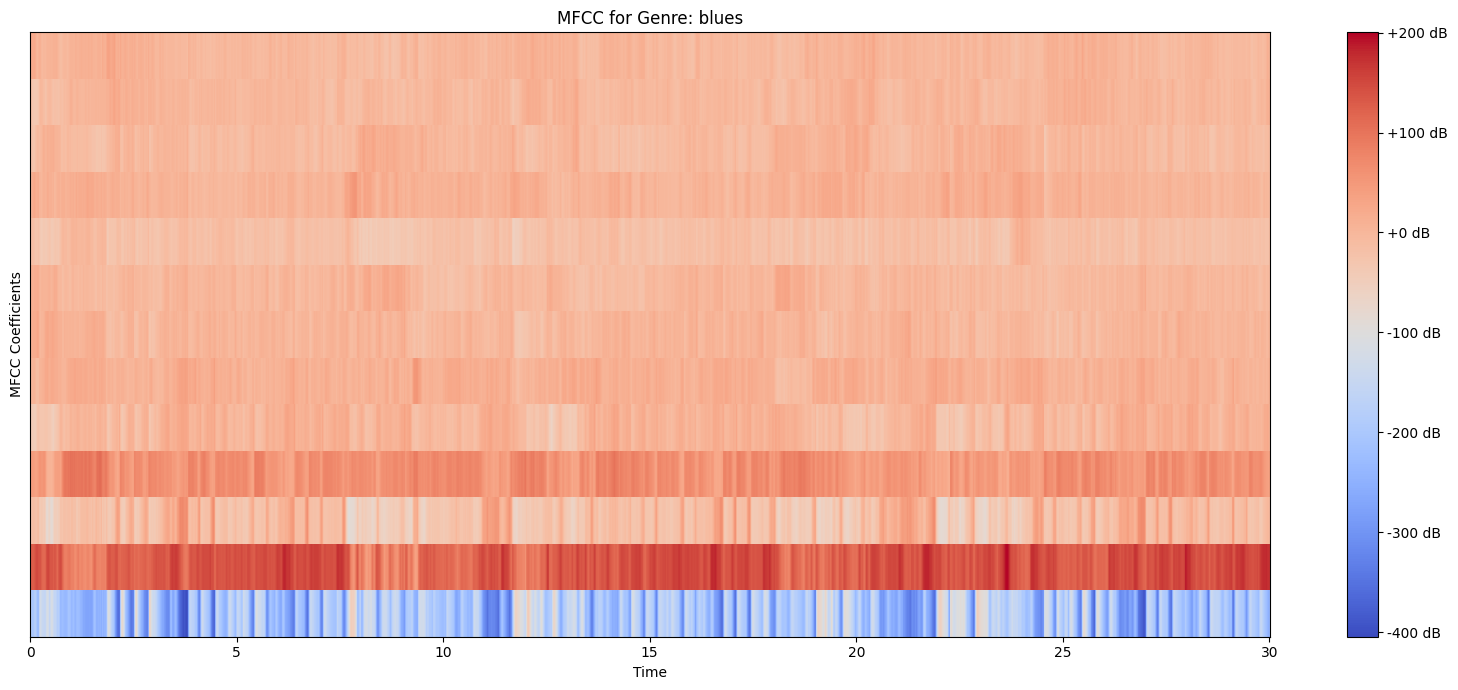

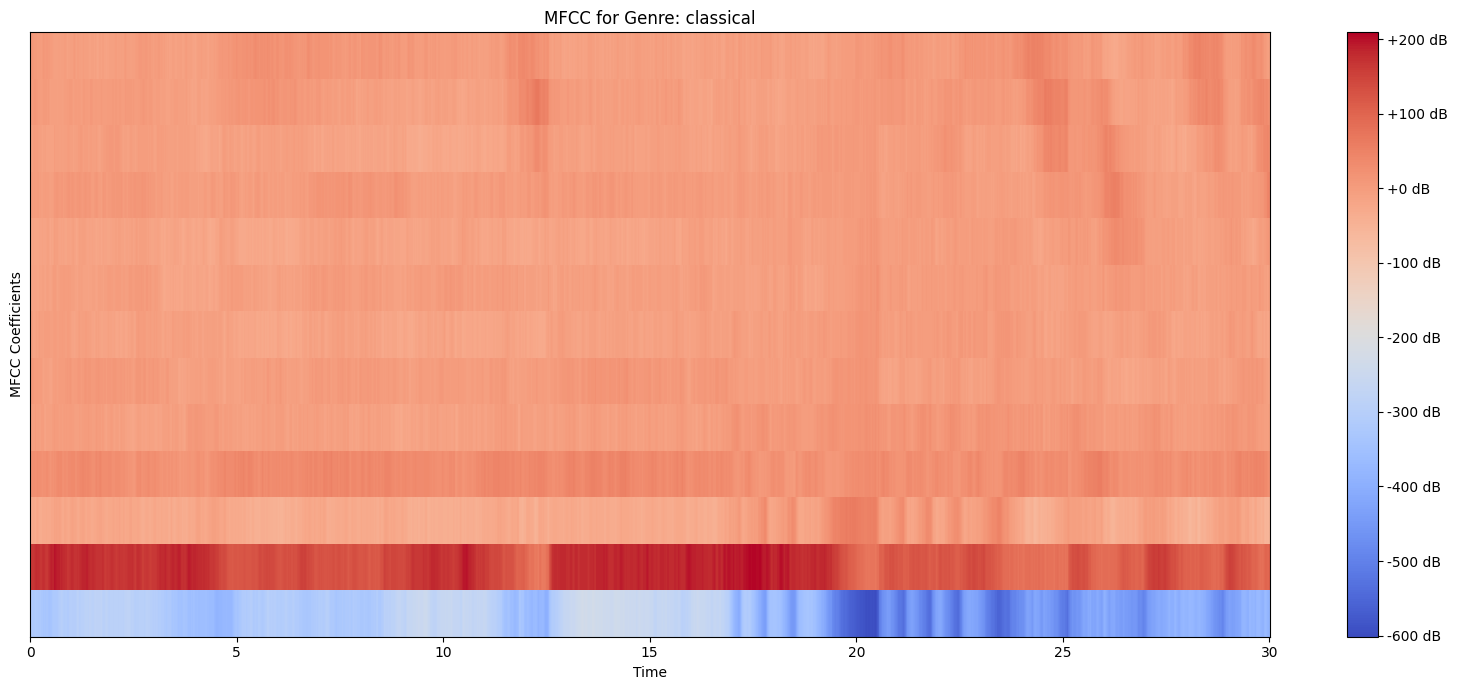

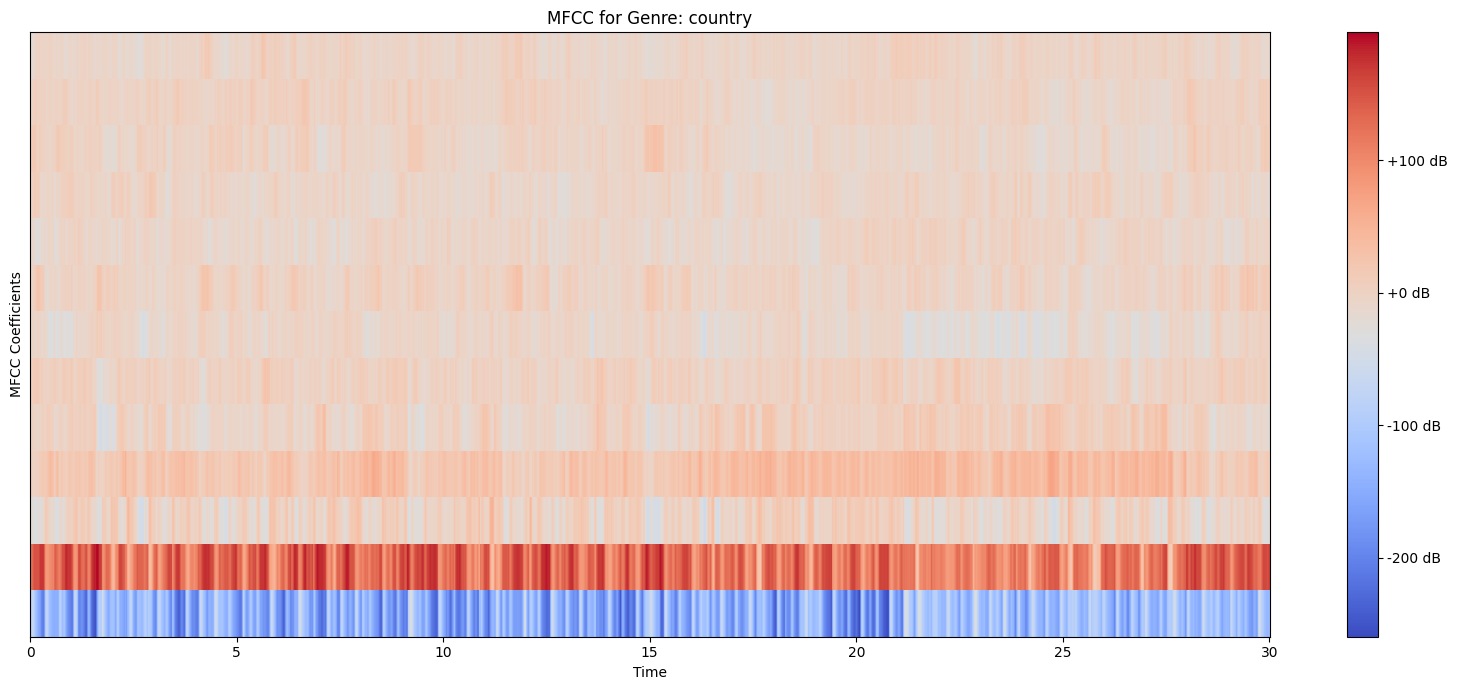

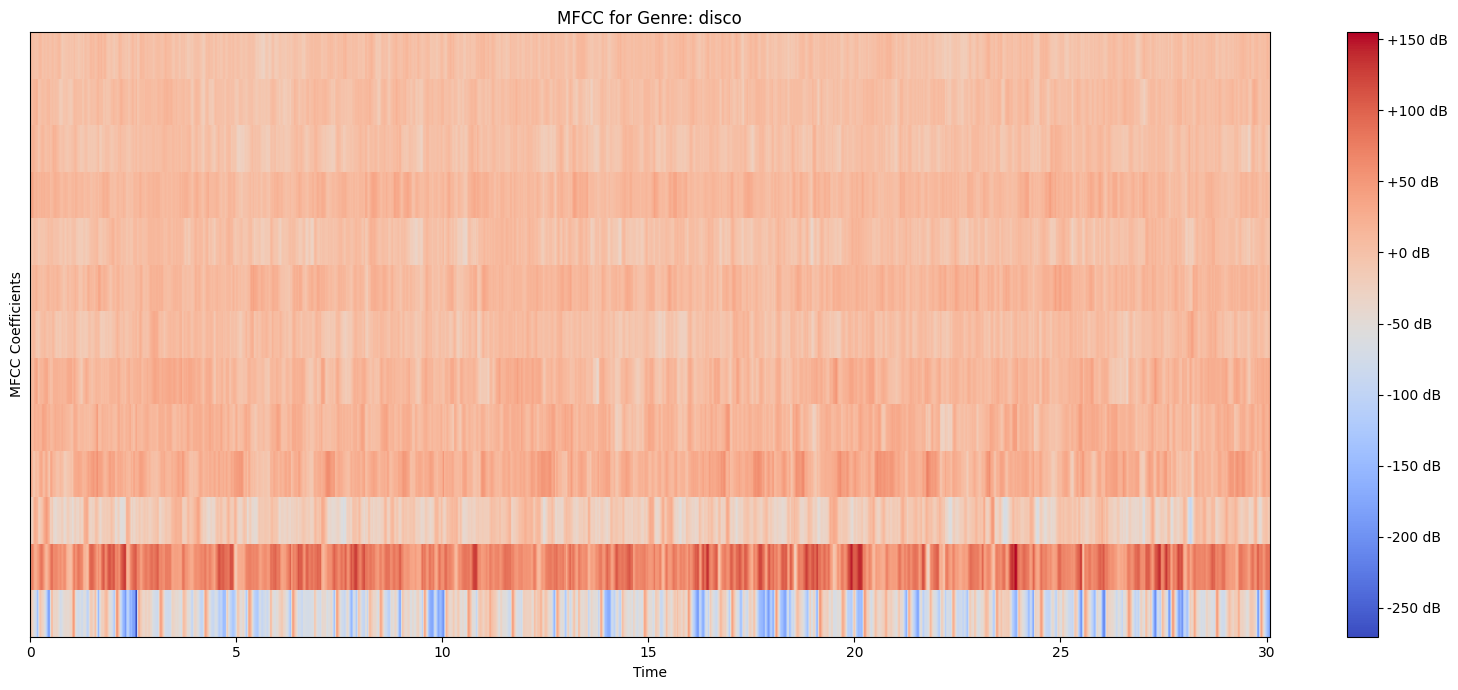

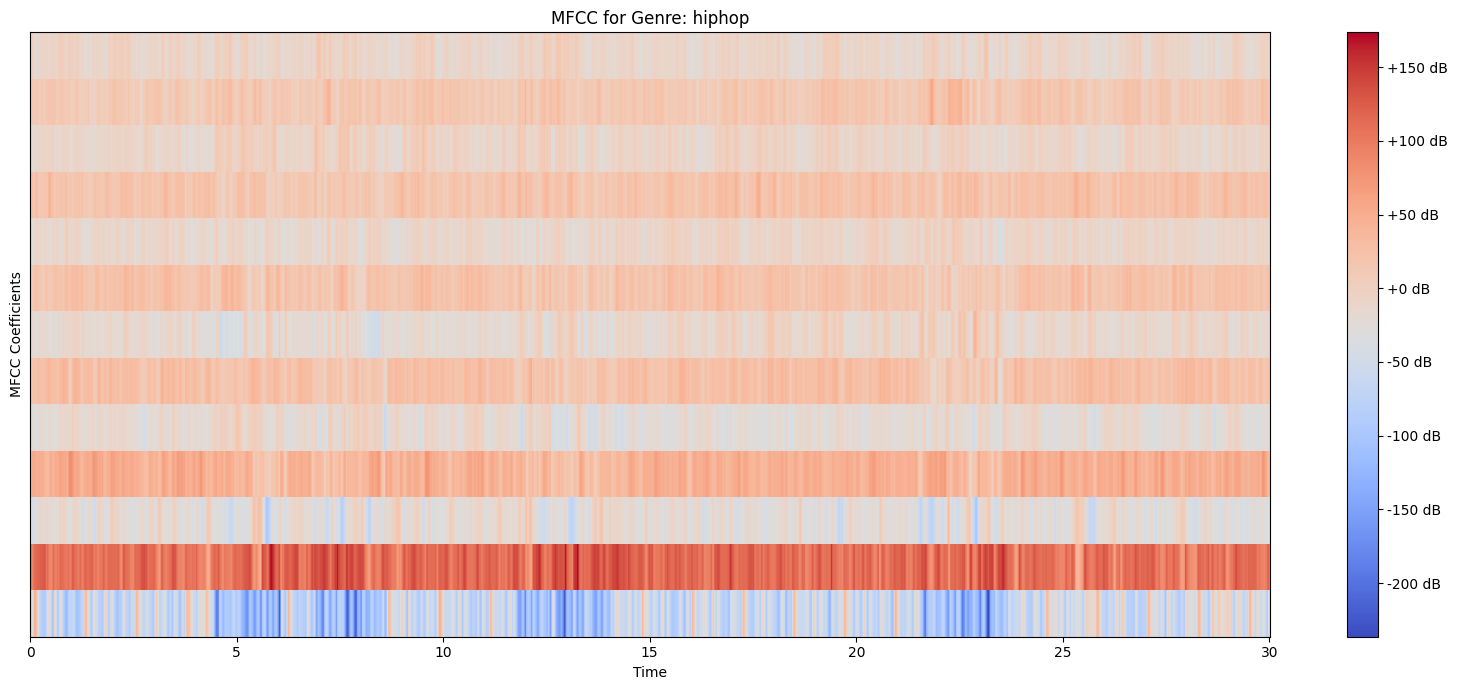

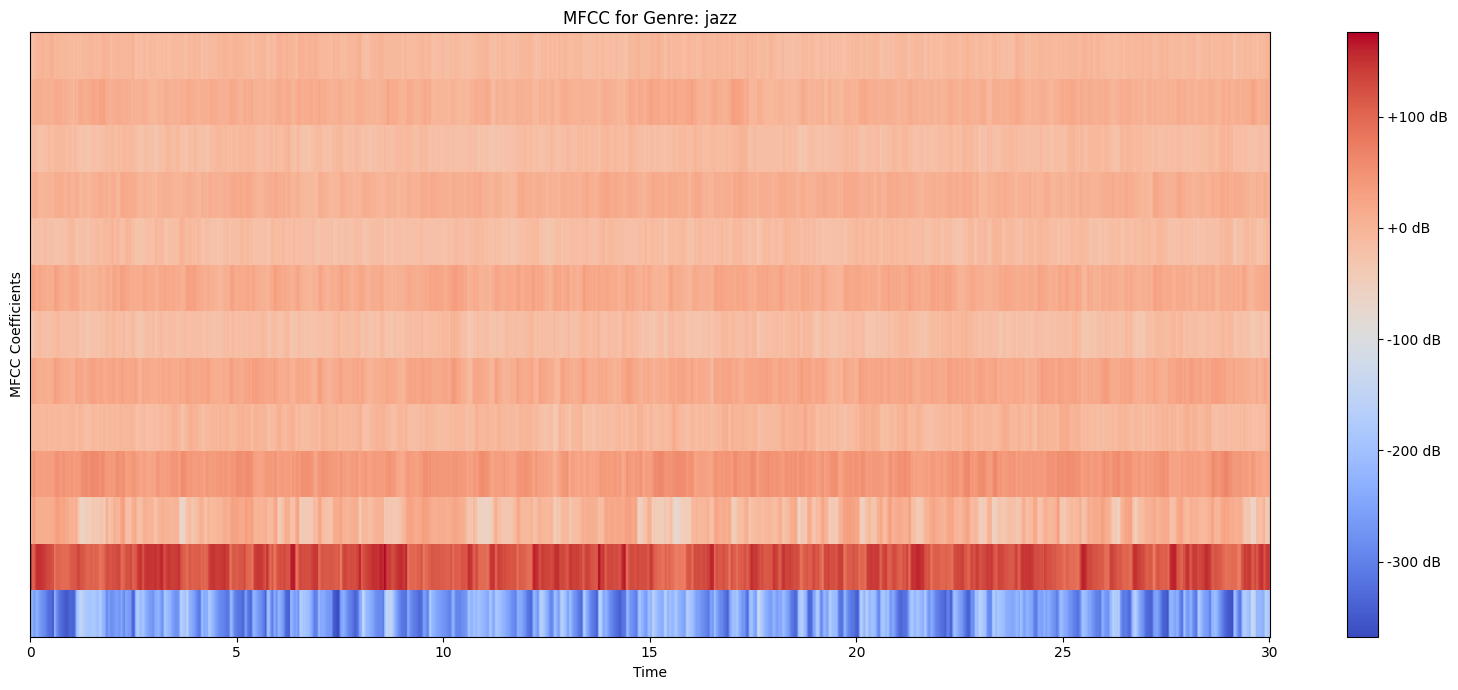

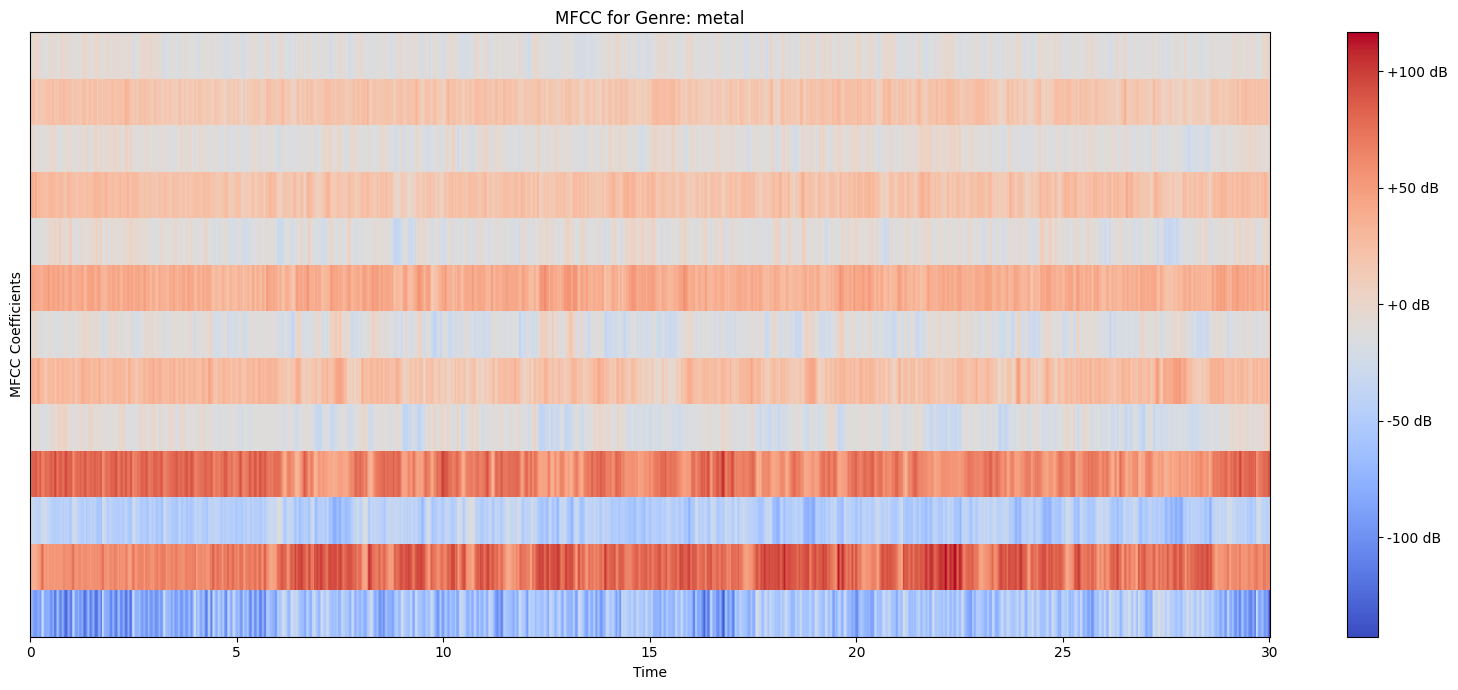

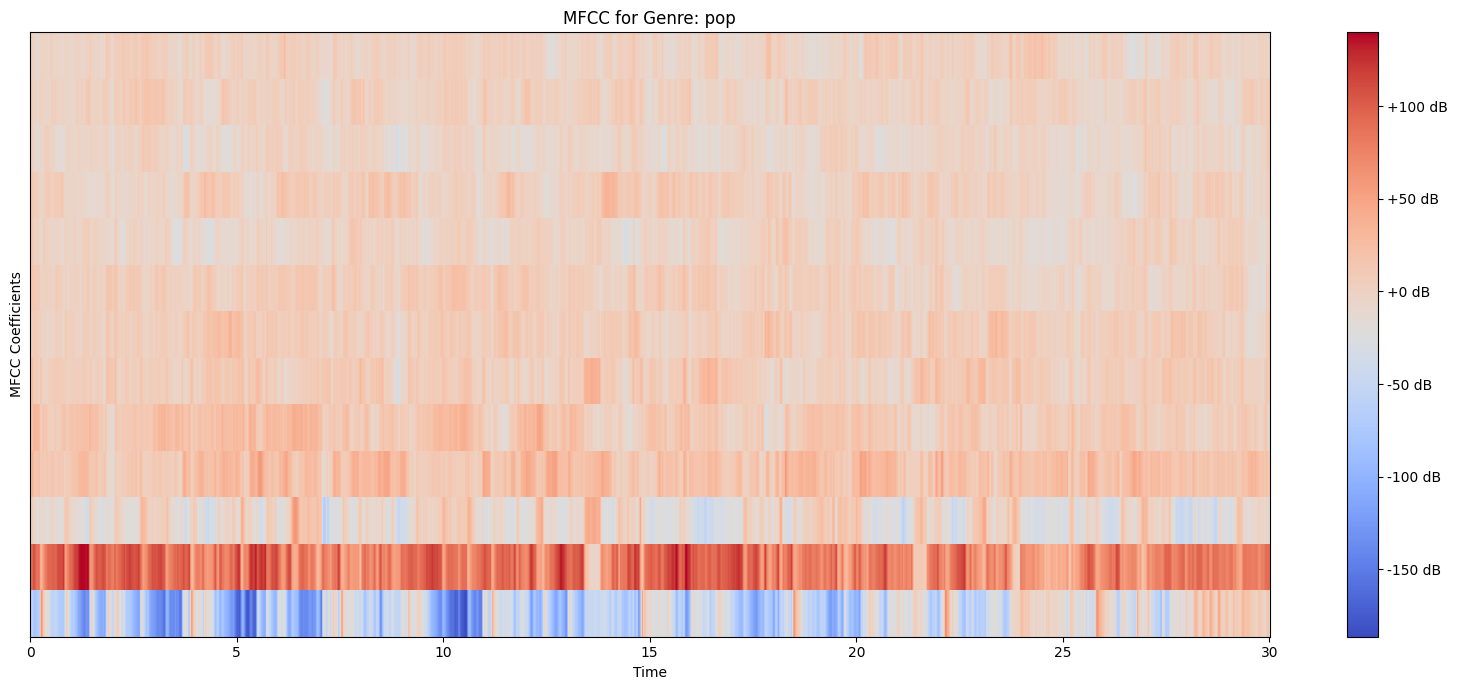

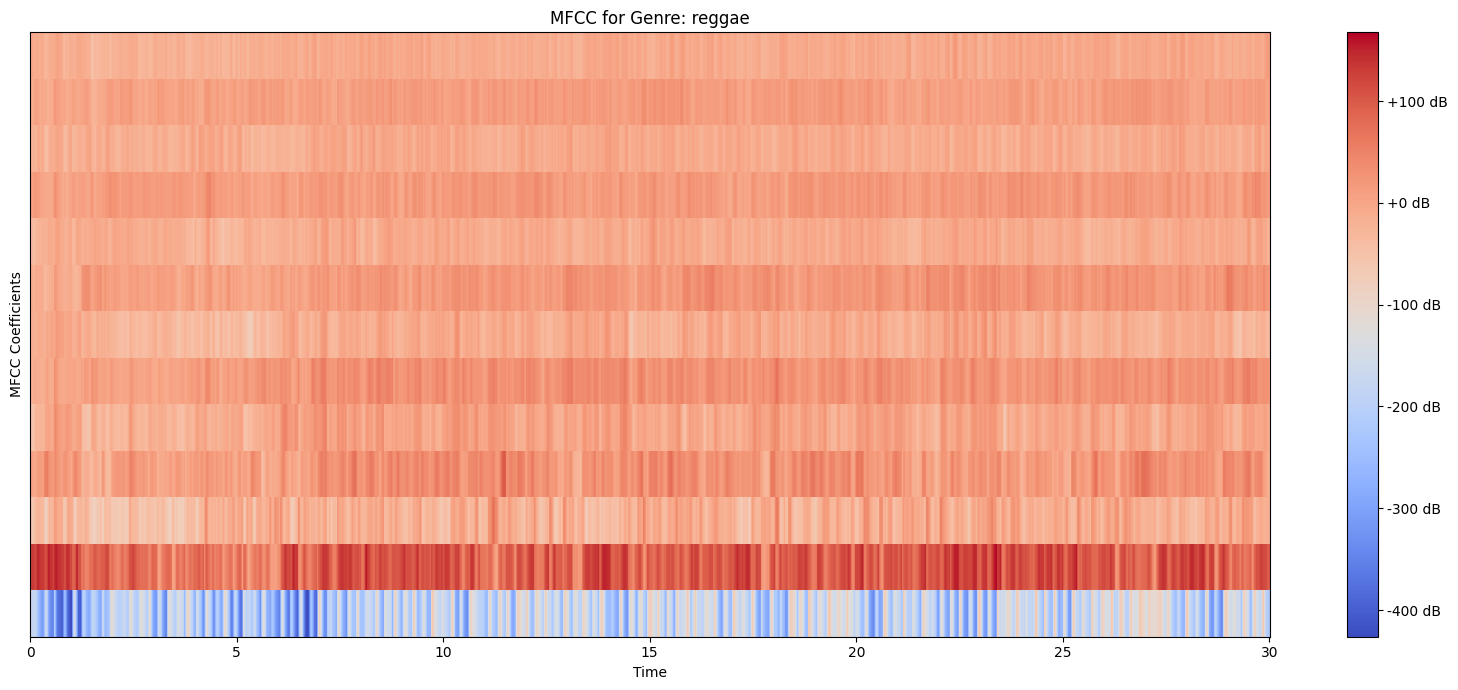

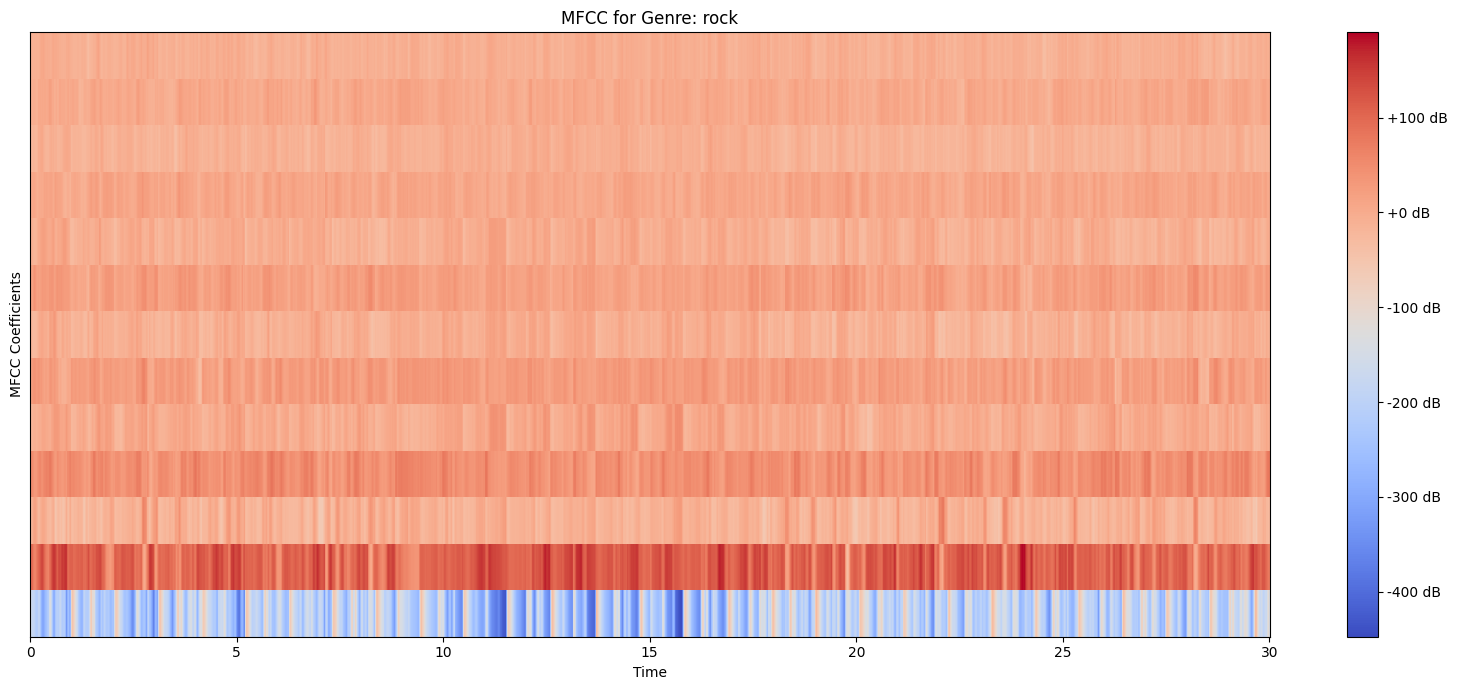

In [ ]:
import os

def plot_mfcc(audio_file):
    y, sr = librosa.load(audio_file)

    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Extract genre name from file path
    genre_name = os.path.basename(os.path.dirname(audio_file))

    # If the genre name contains additional information (e.g., 'reggae.00012'), extract only the first part
    genre_name = genre_name.split('.')[0]

    # Plot MFCCs
    plt.figure(figsize=(16, 7))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC for Genre: {}'.format(genre_name))
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')
    plt.tight_layout()
    plt.show()


plot_mfcc(genres + '/blues/blues.00012.wav')
plot_mfcc(genres + '/classical/classical.00012.wav')
plot_mfcc(genres + '/country/country.00012.wav')
plot_mfcc(genres + '/disco/disco.00012.wav')
plot_mfcc(genres + '/hiphop/hiphop.00012.wav')
plot_mfcc(genres + '/jazz/jazz.00012.wav')
plot_mfcc(genres + '/metal/metal.00012.wav')
plot_mfcc(genres + '/pop/pop.00012.wav')
plot_mfcc(genres + '/reggae/reggae.00012.wav')
plot_mfcc(genres + '/rock/rock.00012.wav')

In [ ]:
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

def prepare_datasets(test_size, validation_size):
    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, random_state=42)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [ ]:
DATA_PATH = folder + 'data_10.json'
X,y = load_data(DATA_PATH)
print("X_shape: ",X.shape)
print("Shape of each X: ",X[1].shape)
print(y[1])

Data succesfully loaded!
X_shape:  (9986, 130, 13)
Shape of each X:  (130, 13)
0


In [ ]:
def plot_history(history):
    fig, axs = plt.subplots(2, figsize=(16, 9))

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def predict(model, X, y, genres_mapping):
    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...]  # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # Get the predicted genre using the genres mapping
    # Define a mapping from index to GTZAN genres

    # Plot predicted probabilities
    plt.figure(figsize=(8, 6))
    plt.bar(genres_mapping.values(), prediction[0], color='blue')
    plt.title('Predicted Probabilities')
    plt.xlabel('Genres')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    # Get the predicted genre
    predicted_genre = genres_mapping[predicted_index[0]]

    # Get the target genre
    target_genre = genres_mapping[y]

    print("Target index: {}, Target genre: {}, \nPredicted index: {}, Predicted genre: {}".format(y, target_genre, predicted_index[0], predicted_genre))

In [ ]:
def build_model(input_shape, dropout):
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())


     # Block 2
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())


     # Block 3
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())


    # Flatten và chuyển vào Dense
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout))

    # Output
    model.add(Dense(10, activation='softmax'))

    return model

In [ ]:
DATA_PATH = folder + 'data_10.json'
# DATA_PATH = 'data_10.json'

# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape[1], X_train.shape[2],1)
model = build_model(input_shape, 0.3)

# compile modela
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

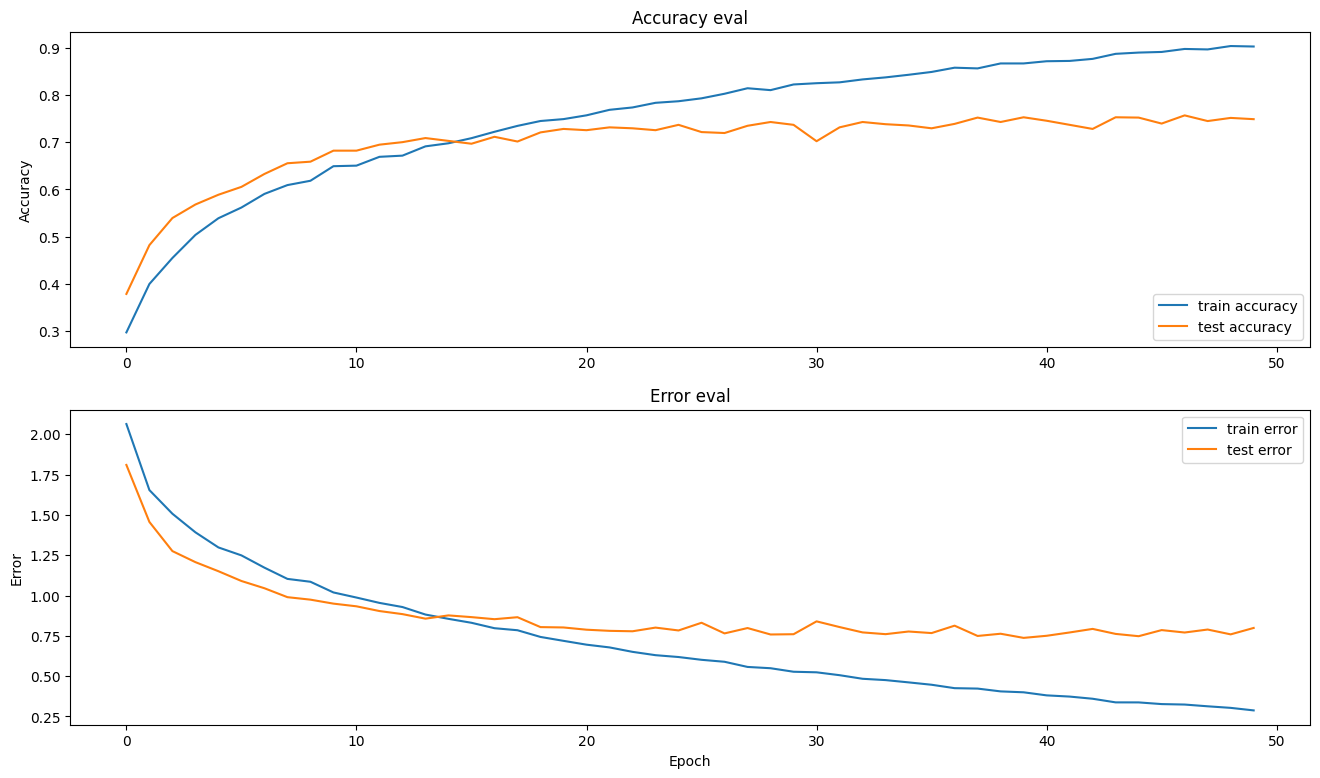

79/79 - 3s - loss: 0.8434 - accuracy: 0.7353 - 3s/epoch - 32ms/step

Test accuracy: 0.7352823615074158


In [ ]:
# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

79/79 [==============================] - 3s 34ms/step


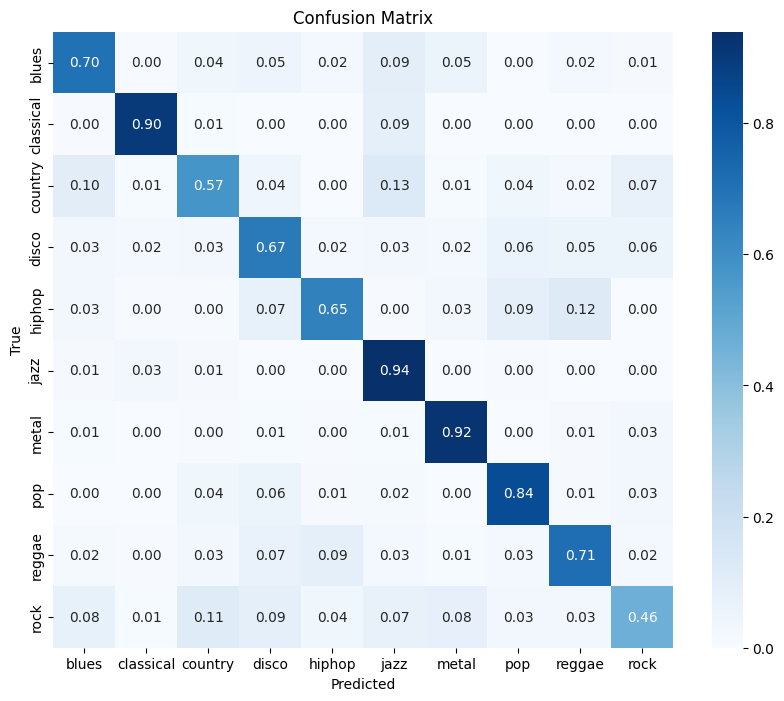

In [ ]:
# Get the predictions for the test set
y_pred = model.predict(X_test)

# Convert y_pred to integer class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Compute the normalized confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix with normalized values
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=genres_mapping.values(), yticklabels=genres_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save('mgr.keras')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/gdrive/My Drive/Music-Data/mgr.keras')

1/1 [==============================] - 0s 34ms/step


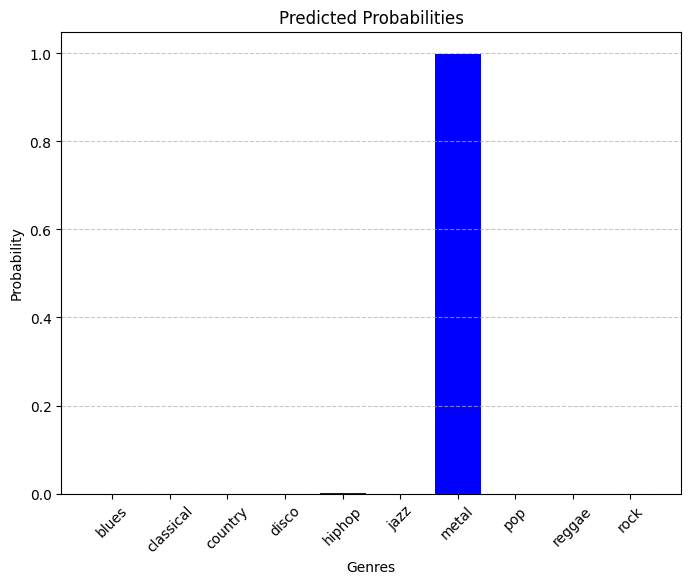

Target index: 6, Target genre: metal, 
Predicted index: 6, Predicted genre: metal
6


In [ ]:
# pick a sample to predict from the test set

index = 356

X_to_predict = X_test[index]
y_to_predict = y_test[index]

# predict sample
predict(model, X_to_predict, y_to_predict, genres_mapping)
print(y_test[index])

In [ ]:
DATASET_PATH = genres
SAMPLE_RATE = 22050
TRACK_DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

def process_input(audio_file, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    mfcc_data = []

    # load audio file
    signal, sample_rate = librosa.load(audio_file, sr=SAMPLE_RATE)

    # process all segments of the audio file
    for d in range(num_segments):

        # calculate start and finish sample for the current segment
        start = samples_per_segment * d
        finish = start + samples_per_segment

        # extract mfcc
        mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T

        # store only mfcc feature with expected number of vectors
        if len(mfcc) == num_mfcc_vectors_per_segment:
            mfcc_data.append(mfcc.tolist())
            print("{}, segment:{}".format(audio_file, d+1))

    return np.array(mfcc_data)

def predict_input(model, X, genres_mapping, audio_file):
    if len(X.shape) != 4:
        X = X[np.newaxis, ...]

    print(X.shape)
    # Perform prediction on each segment
    predictions = model.predict(X)

    # Average the predictions across segments
    avg_prediction = np.mean(predictions, axis=0)

    # Plot predicted probabilities
    plt.figure(figsize=(8, 6))
    plt.bar(genres_mapping.values(), avg_prediction, color='blue')
    plt.title('Predicted Probabilities for: ' + audio_file)
    plt.xlabel('Genres')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Print prediction for each segment
    for i, pred in enumerate(predictions):
        # Get the index with the highest probability for this segment
        segment_pred_index = np.argmax(pred)
        # Get the predicted genre for this segment
        segment_predicted_genre = genres_mapping[segment_pred_index]
        print(f"Segment {i+1} - Predicted Genre: {segment_predicted_genre}")

    # Get the index with the highest average probability
    predicted_index = np.argmax(avg_prediction)

    # Get the predicted genre
    predicted_genre = genres_mapping[predicted_index]

    return predicted_genre

/content/gdrive/My Drive/Music-Data/genres/reggae/reggae.00012.wav, segment:1
/content/gdrive/My Drive/Music-Data/genres/reggae/reggae.00012.wav, segment:2
/content/gdrive/My Drive/Music-Data/genres/reggae/reggae.00012.wav, segment:3
/content/gdrive/My Drive/Music-Data/genres/reggae/reggae.00012.wav, segment:4
/content/gdrive/My Drive/Music-Data/genres/reggae/reggae.00012.wav, segment:5
/content/gdrive/My Drive/Music-Data/genres/reggae/reggae.00012.wav, segment:6
/content/gdrive/My Drive/Music-Data/genres/reggae/reggae.00012.wav, segment:7
/content/gdrive/My Drive/Music-Data/genres/reggae/reggae.00012.wav, segment:8
/content/gdrive/My Drive/Music-Data/genres/reggae/reggae.00012.wav, segment:9
/content/gdrive/My Drive/Music-Data/genres/reggae/reggae.00012.wav, segment:10
(10, 130, 13, 1)
1/1 [==============================] - 0s 104ms/step


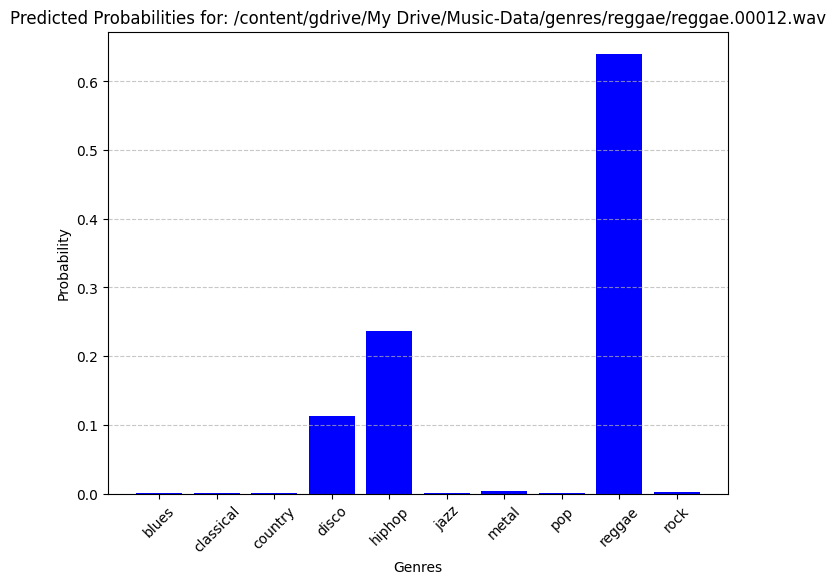

Segment 1 - Predicted Genre: reggae
Segment 2 - Predicted Genre: reggae
Segment 3 - Predicted Genre: reggae
Segment 4 - Predicted Genre: hiphop
Segment 5 - Predicted Genre: reggae
Segment 6 - Predicted Genre: disco
Segment 7 - Predicted Genre: hiphop
Segment 8 - Predicted Genre: reggae
Segment 9 - Predicted Genre: reggae
Segment 10 - Predicted Genre: hiphop


'reggae'

In [ ]:
# Load new audio data and extract MFCC features
audio_file = genres + '/reggae/reggae.00012.wav'  # Path to the new audio file
new_mfcc = process_input(audio_file)

# Reshape to match the input shape expected by the model
new_mfcc = new_mfcc[..., np.newaxis]

# Make predictions
predict_input(model, new_mfcc, genres_mapping, audio_file)

/content/gdrive/My Drive/Music-Data/genres/rock/rock.00012.wav, segment:1
/content/gdrive/My Drive/Music-Data/genres/rock/rock.00012.wav, segment:2
/content/gdrive/My Drive/Music-Data/genres/rock/rock.00012.wav, segment:3
/content/gdrive/My Drive/Music-Data/genres/rock/rock.00012.wav, segment:4
/content/gdrive/My Drive/Music-Data/genres/rock/rock.00012.wav, segment:5
/content/gdrive/My Drive/Music-Data/genres/rock/rock.00012.wav, segment:6
/content/gdrive/My Drive/Music-Data/genres/rock/rock.00012.wav, segment:7
/content/gdrive/My Drive/Music-Data/genres/rock/rock.00012.wav, segment:8
/content/gdrive/My Drive/Music-Data/genres/rock/rock.00012.wav, segment:9
/content/gdrive/My Drive/Music-Data/genres/rock/rock.00012.wav, segment:10
(10, 130, 13, 1)
1/1 [==============================] - 0s 61ms/step


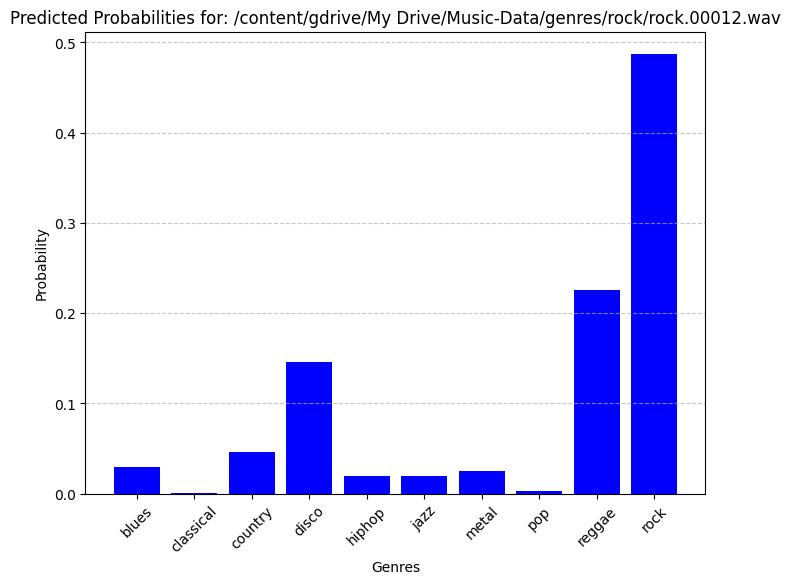

Segment 1 - Predicted Genre: rock
Segment 2 - Predicted Genre: rock
Segment 3 - Predicted Genre: disco
Segment 4 - Predicted Genre: rock
Segment 5 - Predicted Genre: reggae
Segment 6 - Predicted Genre: reggae
Segment 7 - Predicted Genre: rock
Segment 8 - Predicted Genre: rock
Segment 9 - Predicted Genre: rock
Segment 10 - Predicted Genre: rock


'rock'

In [ ]:
# Load new audio data and extract MFCC features
audio_file = genres + '/rock/rock.00012.wav'  # Path to the new audio file
new_mfcc = process_input(audio_file)

# Reshape to match the input shape expected by the model
new_mfcc = new_mfcc[..., np.newaxis]

# Make predictions
predict_input(model, new_mfcc, genres_mapping, audio_file)


/content/gdrive/My Drive/Music-Data/genres/disco/disco.00012.wav, segment:1
/content/gdrive/My Drive/Music-Data/genres/disco/disco.00012.wav, segment:2
/content/gdrive/My Drive/Music-Data/genres/disco/disco.00012.wav, segment:3
/content/gdrive/My Drive/Music-Data/genres/disco/disco.00012.wav, segment:4
/content/gdrive/My Drive/Music-Data/genres/disco/disco.00012.wav, segment:5
/content/gdrive/My Drive/Music-Data/genres/disco/disco.00012.wav, segment:6
/content/gdrive/My Drive/Music-Data/genres/disco/disco.00012.wav, segment:7
/content/gdrive/My Drive/Music-Data/genres/disco/disco.00012.wav, segment:8
/content/gdrive/My Drive/Music-Data/genres/disco/disco.00012.wav, segment:9
/content/gdrive/My Drive/Music-Data/genres/disco/disco.00012.wav, segment:10
(10, 130, 13, 1)
1/1 [==============================] - 0s 55ms/step


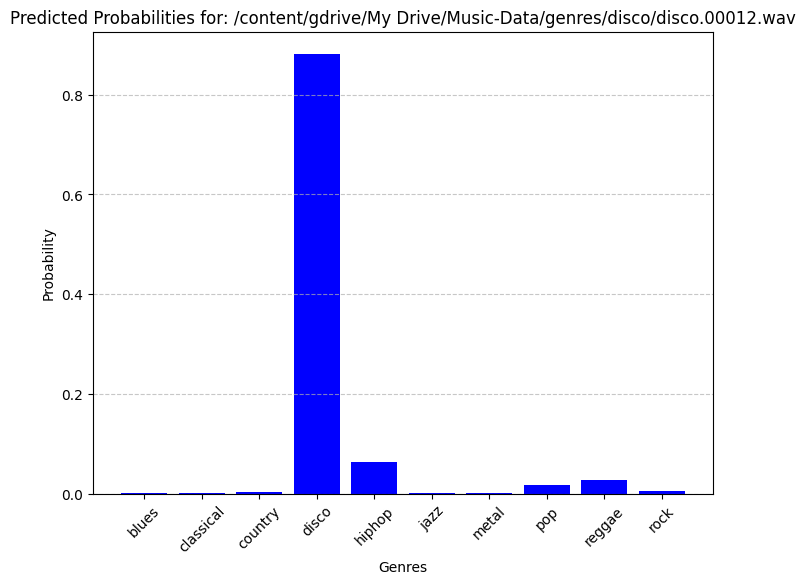

Segment 1 - Predicted Genre: hiphop
Segment 2 - Predicted Genre: disco
Segment 3 - Predicted Genre: disco
Segment 4 - Predicted Genre: disco
Segment 5 - Predicted Genre: disco
Segment 6 - Predicted Genre: disco
Segment 7 - Predicted Genre: disco
Segment 8 - Predicted Genre: disco
Segment 9 - Predicted Genre: disco
Segment 10 - Predicted Genre: disco


'disco'

In [ ]:
# Load new audio data and extract MFCC features
audio_file = genres + '/disco/disco.00012.wav'  # Path to the new audio file
new_mfcc = process_input(audio_file)

# Reshape to match the input shape expected by the model
new_mfcc = new_mfcc[..., np.newaxis]

# Make predictions
predict_input(model, new_mfcc, genres_mapping, audio_file)


/content/gdrive/My Drive/Music-Data/Lacrimosa.wav, segment:1
/content/gdrive/My Drive/Music-Data/Lacrimosa.wav, segment:2
/content/gdrive/My Drive/Music-Data/Lacrimosa.wav, segment:3
/content/gdrive/My Drive/Music-Data/Lacrimosa.wav, segment:4
/content/gdrive/My Drive/Music-Data/Lacrimosa.wav, segment:5
/content/gdrive/My Drive/Music-Data/Lacrimosa.wav, segment:6
/content/gdrive/My Drive/Music-Data/Lacrimosa.wav, segment:7
/content/gdrive/My Drive/Music-Data/Lacrimosa.wav, segment:8
/content/gdrive/My Drive/Music-Data/Lacrimosa.wav, segment:9
/content/gdrive/My Drive/Music-Data/Lacrimosa.wav, segment:10
(10, 130, 13, 1)
1/1 [==============================] - 0s 38ms/step


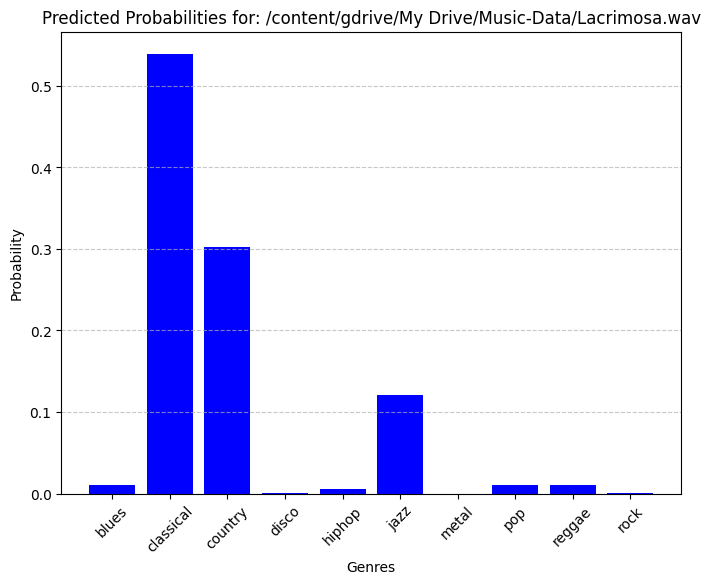

Segment 1 - Predicted Genre: classical
Segment 2 - Predicted Genre: classical
Segment 3 - Predicted Genre: classical
Segment 4 - Predicted Genre: country
Segment 5 - Predicted Genre: classical
Segment 6 - Predicted Genre: jazz
Segment 7 - Predicted Genre: country
Segment 8 - Predicted Genre: country
Segment 9 - Predicted Genre: classical
Segment 10 - Predicted Genre: classical


'classical'

In [ ]:
# Load new audio data and extract MFCC features
audio_file = folder + 'Lacrimosa.wav'  # Path to the new audio file
new_mfcc = process_input(audio_file)

# Reshape to match the input shape expected by the model
new_mfcc = new_mfcc[..., np.newaxis]

# Make predictions
predict_input(model, new_mfcc, genres_mapping, audio_file)


/content/gdrive/My Drive/Music-Data/hiphop snippet.wav, segment:1
/content/gdrive/My Drive/Music-Data/hiphop snippet.wav, segment:2
/content/gdrive/My Drive/Music-Data/hiphop snippet.wav, segment:3
/content/gdrive/My Drive/Music-Data/hiphop snippet.wav, segment:4
/content/gdrive/My Drive/Music-Data/hiphop snippet.wav, segment:5
/content/gdrive/My Drive/Music-Data/hiphop snippet.wav, segment:6
/content/gdrive/My Drive/Music-Data/hiphop snippet.wav, segment:7
/content/gdrive/My Drive/Music-Data/hiphop snippet.wav, segment:8
/content/gdrive/My Drive/Music-Data/hiphop snippet.wav, segment:9
/content/gdrive/My Drive/Music-Data/hiphop snippet.wav, segment:10
(10, 130, 13, 1)
1/1 [==============================] - 0s 36ms/step


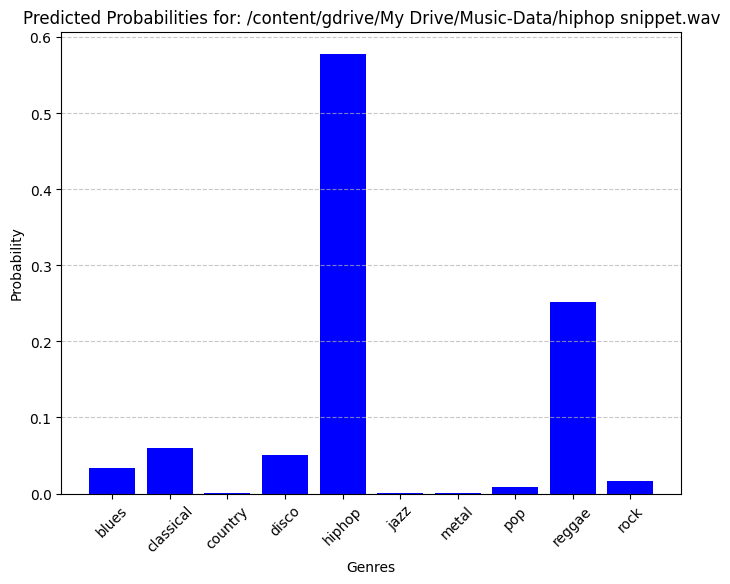

Segment 1 - Predicted Genre: classical
Segment 2 - Predicted Genre: reggae
Segment 3 - Predicted Genre: hiphop
Segment 4 - Predicted Genre: hiphop
Segment 5 - Predicted Genre: hiphop
Segment 6 - Predicted Genre: hiphop
Segment 7 - Predicted Genre: hiphop
Segment 8 - Predicted Genre: hiphop
Segment 9 - Predicted Genre: reggae
Segment 10 - Predicted Genre: reggae


'hiphop'

In [ ]:
# Load new audio data and extract MFCC features
audio_file = folder + 'hiphop snippet.wav'  # Path to the new audio file
new_mfcc = process_input(audio_file)

# Reshape to match the input shape expected by the model
new_mfcc = new_mfcc[..., np.newaxis]

# Make predictions
predict_input(model, new_mfcc, genres_mapping, audio_file)
